In [1]:
import pathlib
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import pysofaconventions as sfa

In [2]:
aPath = './datasets/ari/dtf_nh2.sofa' # take the file that we had downloaded earlier...

parsedPath = pathlib.Path(aPath)
aFilename = aPath.split('/')[-1]

print("path:\t" + aPath)
theFile = sfa.SOFAFile(parsedPath, 'r') # ...and open it

path:	./datasets/ari/dtf_nh2.sofa


In [3]:
theFile.printSOFADimensions()

# one emitter (speaker), two receivers (ears), 256-pt IR, at 1550 locations

- I : 1
- C : 3
- Number of receivers (R) : 2
- Number of emitters (E) : 1
- Number of data samples (N) : 256
- Number of measurements (M) : 1550
- S : 0


-----

## The cell below shows the data  inside the SOFA file and their dimensions.

Some notes...
- The receiver positions are the positions of the (microphones at the) ears
- I'm pretty sure the listener position is always the midpoint of the interaural axis
- ListenerUp and ListenerView is are the "normal vector" of the listener's head.
    - I'm pretty sure the ListenerView vector pointing from ListenerPosition is always consistent with 0deg elevation and 0deg azimuth.
- The spherical coordinate convention for HRTFs:
    - **positive azimuth** corresponds to **CCW** and $\phi \in [0,360)$
    - **positive elevation** corresponds to **up** and $\theta \in [-90,+90]$
    - it's more likely for elevation measurements to **not** span the whole range, although it sometimes happens with azimuth

-----


In [4]:
theFile.printSOFAVariables()

- ListenerPosition = (1, 3)
- ReceiverPosition = (2, 3, 1)
- SourcePosition = (1550, 3)
- EmitterPosition = (1, 3, 1)
- ListenerUp = (1, 3)
- ListenerView = (1, 3)
- MeasurementSourceAudioChannel = (1550,)
- MeasurementAudioLatency = (1550, 2)
- Data.IR = (1550, 2, 256)
- Data.SamplingRate = (1,)
- Data.Delay = (1, 2)


In [5]:
# To fetch data from the file, just call one of the getters.

# for the scope of our project, we probably only need these two
data_IR =       np.array(theFile.getDataIR())
data_coords =   np.array(theFile.getSourcePositionValues())

# For the others, Jupyter should also autocomplete when you start typing "theFile.get ..."

print("data dimensions:\t" + str(data_IR.shape))
print("coordinate dimensions:\t" + str(data_coords.shape))

data dimensions:	(1550, 2, 256)
coordinate dimensions:	(1550, 3)


In [6]:
# compute HRTF (can drop half because input is real)

fftSize = data_IR.shape[2]
data_TF = np.split(fft.fft(data_IR, fftSize, 2), 2, 2)[0]
data_TFfreq = np.split(fft.fftfreq(fftSize, 1./np.array(theFile.getSamplingRate())), 2)[0]

print('HRTF dimensions: ' + str(data_TF.shape))

HRTF dimensions: (1550, 2, 128)


In [7]:
# search for the frontal HRTF

frontal_idx = 0
for entry in data_coords:
    if np.all(entry[:2]==[0,0]):
        break
    frontal_idx+=1

# I just wanted get practice with python ...

coord_labels = ['azim', 'elev', 'radius']
coord_units = theFile.getSourcePositionInfo()[0].split(', ')

print('Frontal HRTF found:\n-------------------')
for it1,it2,it3 in np.nditer([coord_labels, data_coords[frontal_idx], coord_units]):
    print(str(it1)+ ':\t' + str(it2) + ' ' + str(it3) + 's')


Frontal HRTF found:
-------------------
azim:	0.0 degrees
elev:	0.0 degrees
radius:	1.2 metres


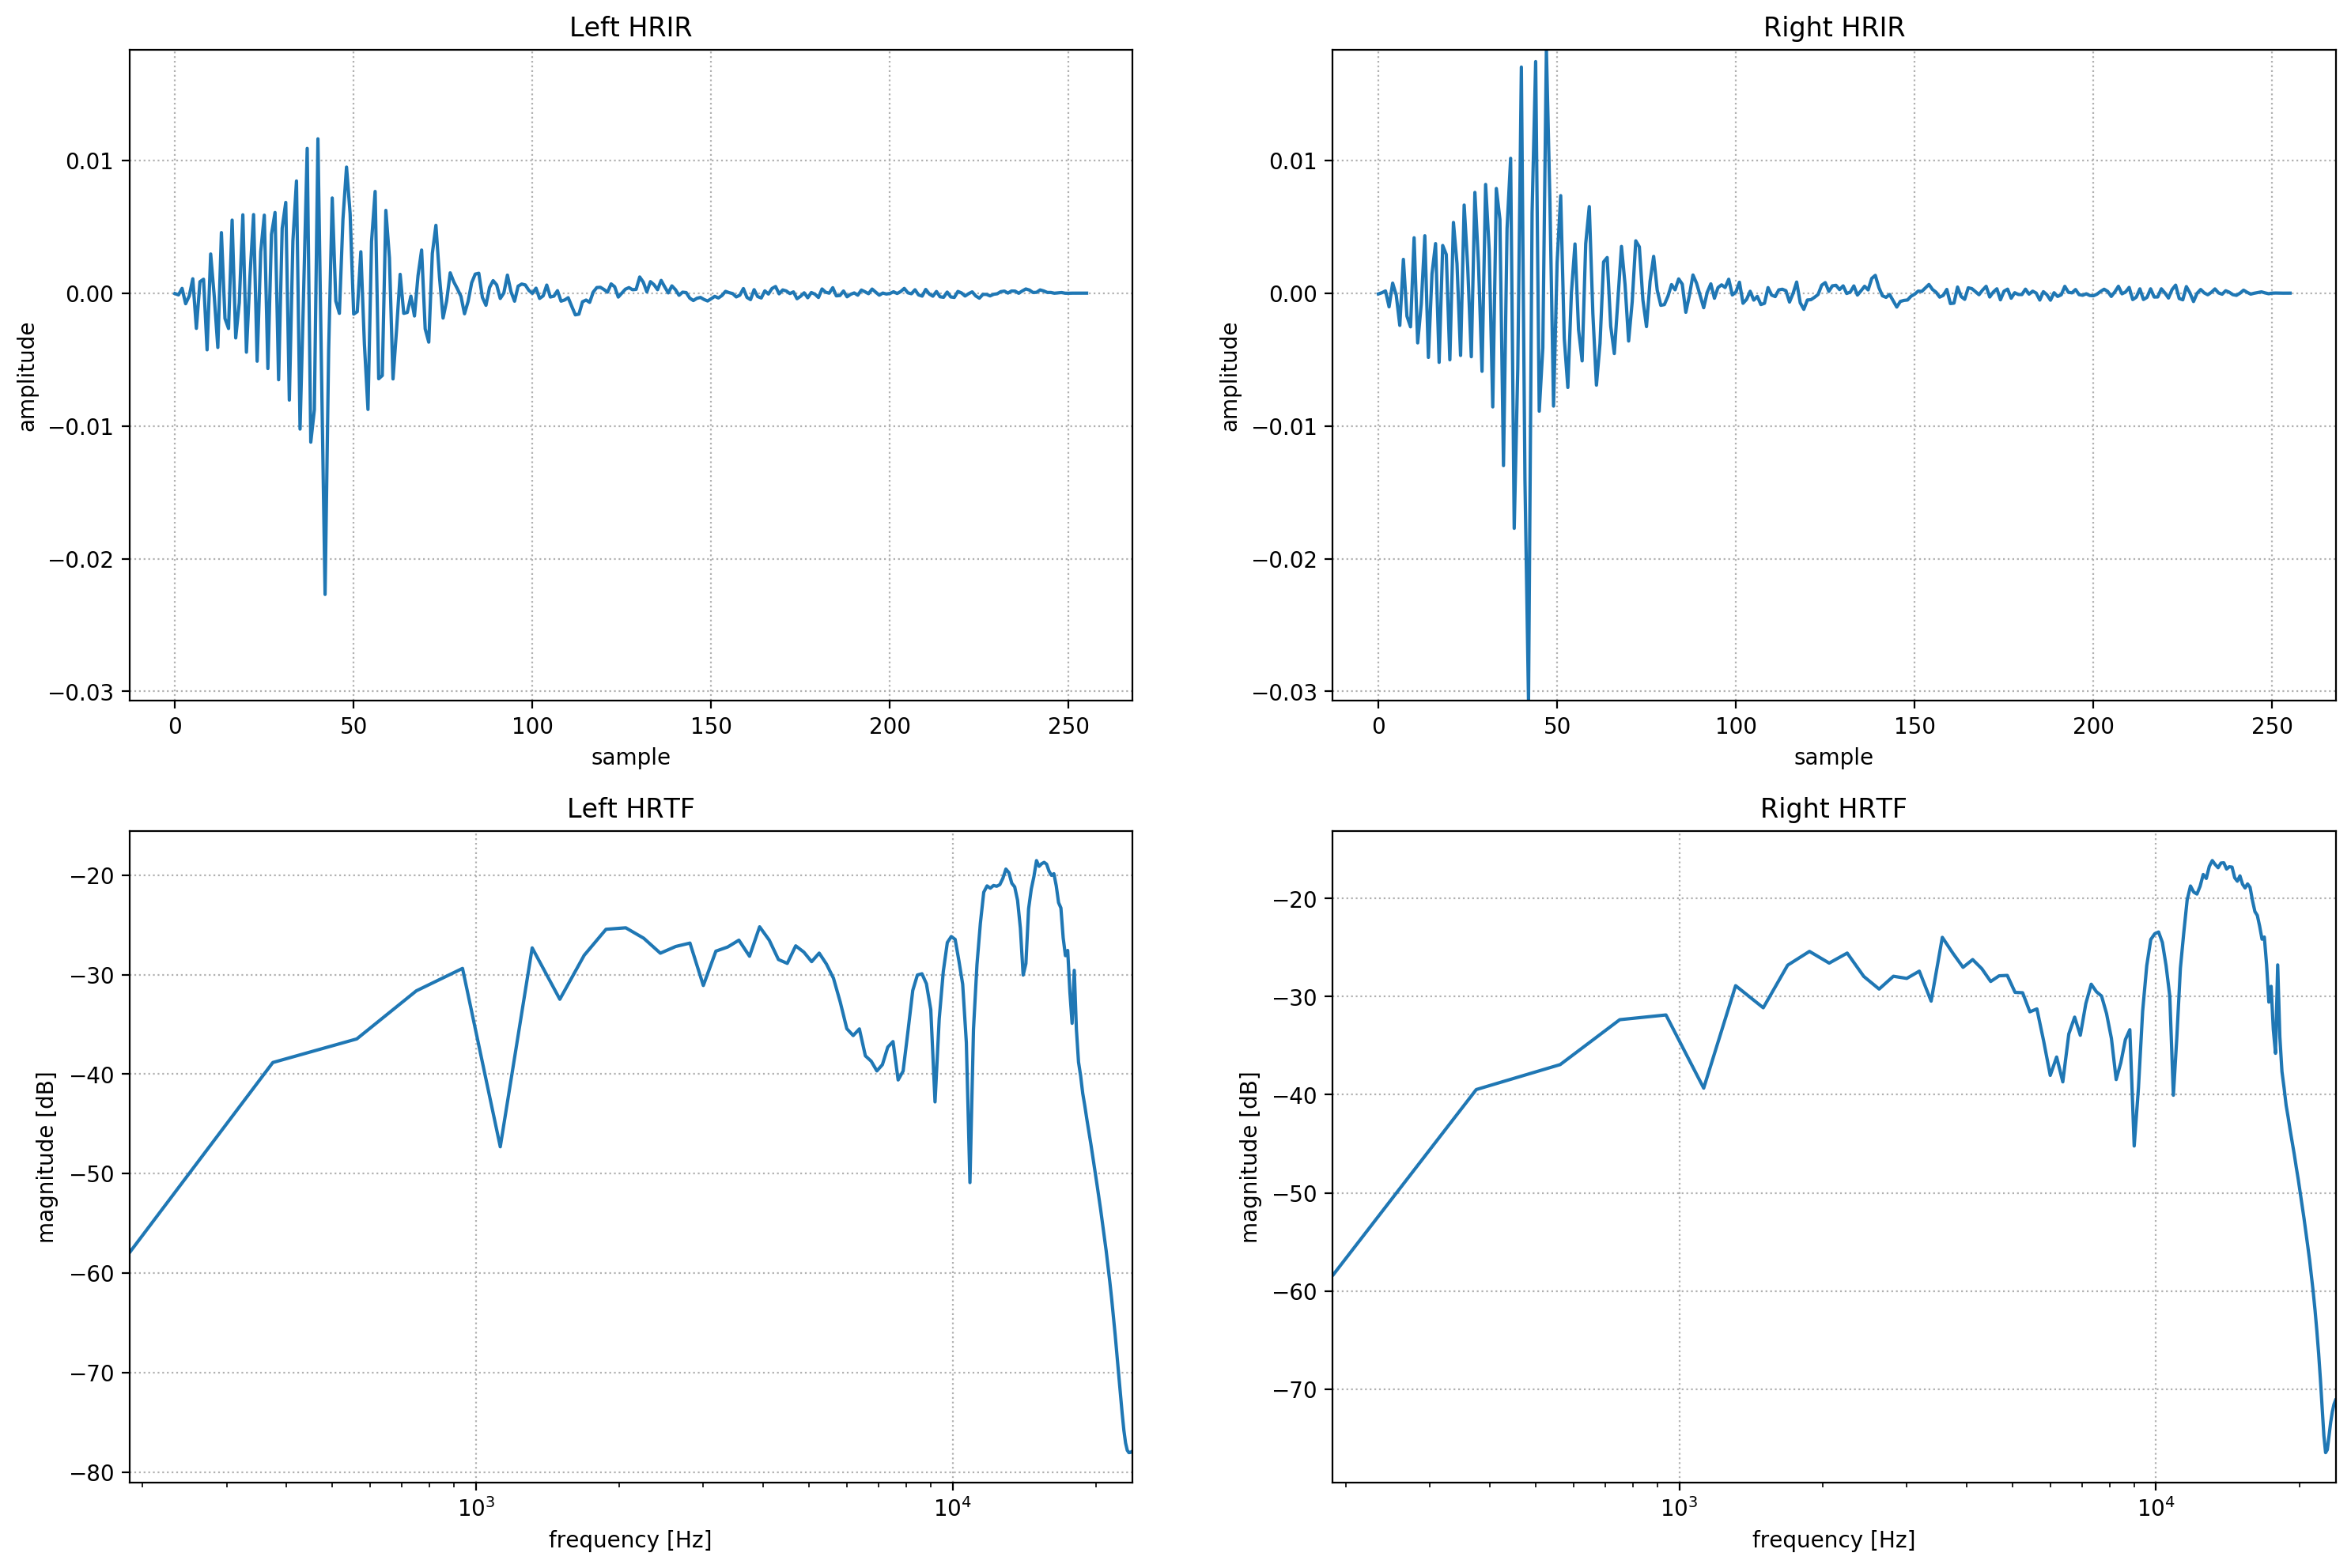

In [8]:
idx = frontal_idx # index of the frontal hrtf...

plt.figure(figsize=(18,12), dpi=200)

ax1 = plt.subplot(2,2,1)
plt.plot(np.arange(len(data_IR[idx,0,:])) , data_IR[idx,0,:])
plt.ylim(np.min(data_IR[idx,:,:]), np.max(data_IR[idx,:,:]))
plt.grid(ls=':')
plt.xlabel("sample")
plt.ylabel("amplitude")
plt.title("Left HRIR")

plt.subplot(2,2,2, sharex=ax1)
plt.plot(np.arange(len(data_IR[idx,1,:])) , data_IR[idx,1,:])
plt.ylim(np.min(data_IR[idx,:,:]), np.max(data_IR[idx,:,:]))
plt.grid(ls=':')
plt.xlabel("sample")
plt.ylabel("amplitude")
plt.title("Right HRIR")

ax3 = plt.subplot(2,2,3)
plt.plot(data_TFfreq, 20*np.log10(np.abs(data_TF[idx,0,:])) )
#plt.ylim(np.min(hrir_data[idx,:,:]), np.max(hrir_data[idx,:,:]))
plt.grid(ls=':')
plt.xscale("log")
plt.xlim(data_TFfreq[1], data_TFfreq[-1])
plt.xlabel("frequency [Hz]")
plt.ylabel("magnitude [dB]")
plt.title("Left HRTF")

spRight = plt.subplot(2,2,4, sharex=ax3)
plt.plot(data_TFfreq, 20*np.log10(np.abs(data_TF[idx,1,:])) )
#plt.ylim(np.min(hrir_data[idx,:,:]), np.max(hrir_data[idx,:,:]))
plt.grid(ls=':')
plt.xscale("log")
plt.xlabel("frequency [Hz]")
plt.ylabel("magnitude [dB]")
plt.title("Right HRTF")

plt.show()
